In [1]:
%matplotlib inline

from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pyflux as pf
import statsmodels as ss
import seaborn as sns
import sys
import warnings

### Data Prep and EDA

In [2]:
# load data and convert to datetime
df = pd.read_csv('../data/orderproducts_top20.csv', parse_dates=[1], infer_datetime_format=True)

In [3]:
prod_monthly = pd.crosstab(df['order_date'], df['product_sku']).resample('M').sum()

In [6]:
prod_monthly = prod_monthly['2018-01':'2021-02'] ; prod_monthly

product_sku,EFX-FLY-BLK,M80-2B-BLK,M80-2G-BLK,M80-AC-BLK,M80-AD-BLK,M80-BTY-BLK-L,M80-BTY-BLK-S,M80-EB-BLK,M80-EG-BLK,M80-SEB-BLK,M80-SEG-ASH,M80-SEG-BLK,M80-TICK-V2-BLK,M80-TOUR-V2-BLK,M80-VAD-BLK,M80-VEB-BLK,M80-VEB-GRY,M80-VEG-BLK,M80-VEG-GRY,M80-VHB-BLK
order_date,,,,,,,,,,,,,,,,,,,,
2018-01-31,16,12,22,12,15,11,8,11,17,27,12,15,25,16,14,8,15,33,5,18
2018-02-28,24,9,13,10,5,12,3,22,24,14,15,13,24,22,6,6,12,7,3,7
2018-03-31,21,6,7,0,16,14,6,13,14,2,4,11,16,14,6,14,5,6,9,18
2018-04-30,39,25,37,22,22,26,20,26,35,28,31,31,35,19,25,35,17,100,29,38
2018-05-31,27,10,23,11,17,14,6,13,21,10,14,13,18,18,9,17,12,19,4,14
2018-06-30,37,13,16,6,8,11,15,19,16,7,8,10,19,8,22,20,8,18,13,20
2018-07-31,34,8,21,17,14,12,14,12,19,9,10,9,17,9,11,16,10,14,13,14
2018-08-31,12,6,8,6,7,8,8,3,10,6,7,4,10,6,8,15,6,21,3,12
2018-09-30,22,4,3,4,3,7,1,4,3,3,2,0,13,3,4,7,2,5,2,8


In [7]:
prod_weekly = pd.crosstab(df['order_date'], df['product_sku']).resample('W').sum()

In [8]:
monthly_temp = prod_monthly[['EFX-FLY-BLK']]
weekly_temp = prod_weekly[['EFX-FLY-BLK']]

In [9]:
# describe
monthly_temp.describe()

product_sku,EFX-FLY-BLK
count,38.000000
mean,11.921053
std,10.033408
min,0.000000
25%,4.250000
50%,9.500000
75%,14.000000
max,39.000000


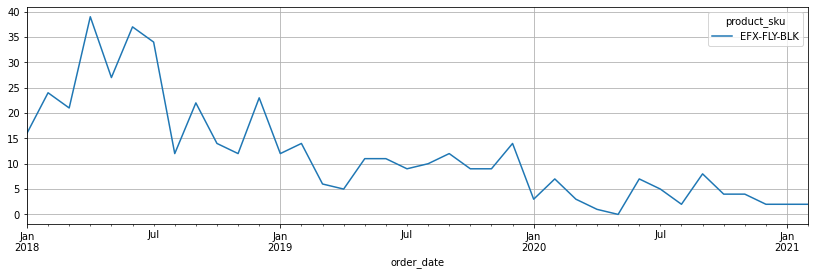

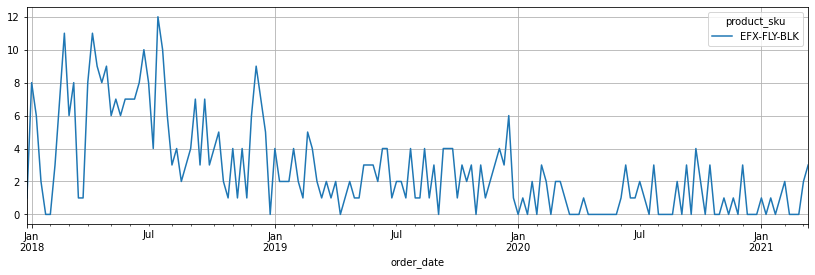

In [10]:
# resample to annual and plot each
plt.rcParams['figure.figsize'] = [14, 4]
monthly_temp.plot(grid=True)
weekly_temp.plot(grid=True);

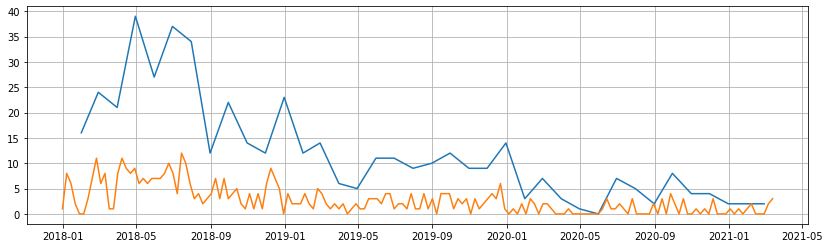

In [11]:
# plot both on same figure
plt.plot(monthly_temp)
plt.plot(weekly_temp)
plt.grid();

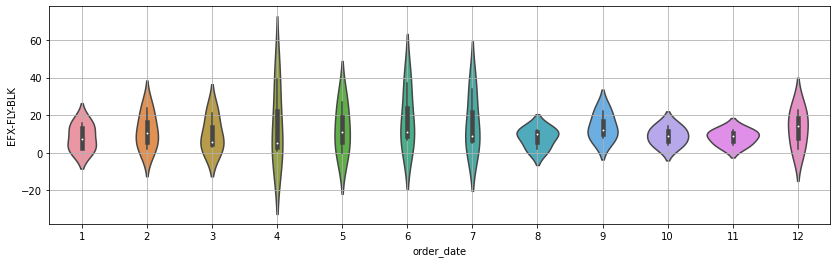

In [12]:
# violinplot of months to determine variance and range
sns.violinplot(x=monthly_temp.index.month, y=monthly_temp['EFX-FLY-BLK'])
plt.grid();

Are these datasets stationary? We can look at a few things per the list above:
- including a visual check (there is a downward trend for the monthly figures, weekly number maybe too small to assess), 
- a standard deviation check on various differences (smallest one is usually most stationary), 
- the formal Dickey-Fuller test.

In [13]:
# check montly deviations for various diffs
print(monthly_temp['EFX-FLY-BLK'].std())
print(monthly_temp['EFX-FLY-BLK'].diff().std()) # theoretically lowest, but not as close to 1 as desired
print(monthly_temp['EFX-FLY-BLK'].diff().diff().std()) 
print(monthly_temp['EFX-FLY-BLK'].diff().diff().diff().std())

10.033407922420755
7.383733440443223
12.970540491240934
24.281161214323465


In [14]:
# check annual deviations for various diffs
print(weekly_temp['EFX-FLY-BLK'].std()) # 
print(weekly_temp['EFX-FLY-BLK'].diff().std())
print(weekly_temp['EFX-FLY-BLK'].diff().diff().std())
print(weekly_temp['EFX-FLY-BLK'].diff().diff().diff().std())

2.776016217414778
2.3972575293600484
3.910966037779845
6.997217269714161


In [15]:
# define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic         -1.062473e+01
p-value                 5.401492e-19
Lags Used               0.000000e+00
Observations Used       3.600000e+01
Critical Value (1%)    -3.626652e+00
Critical Value (5%)    -2.945951e+00
Critical Value (10%)   -2.611671e+00
dtype: float64


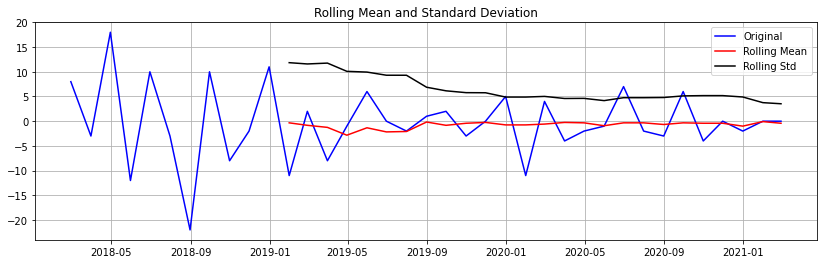

In [16]:
# run DFT on monthly
dftest(monthly_temp['EFX-FLY-BLK'].diff()[1:])
# p-value allows us to reject a unit root: data is stationary

- The t-statistics of -10.6 is less than 1% CF
- The p-value of 5.4e-19 is less than 0,05
We can therefore reject the null hypothesis as non-stationary (i.e. the data is stationary).

#### Forecasting with Triple Exponential
- can pick up trends and seasonality

In [86]:
period = 3
train = np.array(monthly_temp[:-period]['EFX-FLY-BLK'])
test  = np.array(monthly_temp[-period:]['EFX-FLY-BLK'])

In [76]:
def mse(observations, estimates):
    '''
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Square Error value
    '''
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)
    
    return mse

In [79]:
from statsmodels.tsa.api import ExponentialSmoothing
triple = ExponentialSmoothing(train,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=6).fit(optimized=True)
triple_preds = triple.forecast(len(test))
triple_mse = mse(test, triple_preds)
print("Predictions: ", triple_preds)
print("MSE: ", triple_mse)

Predictions:  [11.08611345  4.83632342  3.61698205]
MSE:  93.21681920149462


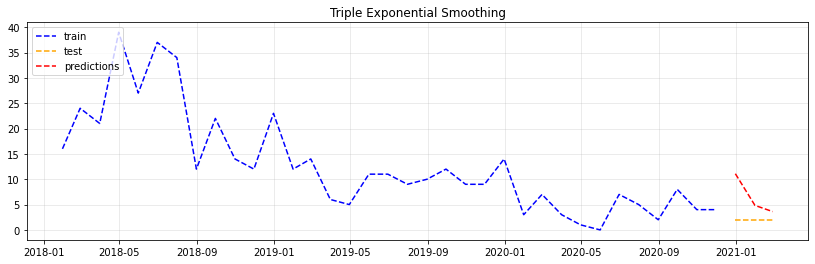

In [80]:
plt.plot(monthly_temp.index[:-period], train, 'b--', label="train")
plt.plot(monthly_temp.index[-period:], test, color='orange', linestyle="--", label="test")
plt.plot(monthly_temp.index[-period:], triple_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Triple Exponential Smoothing")
plt.grid(alpha=0.3);

#### Autocorrelation

In [83]:
def run_sequence_plot(x, y, title, xlabel="time", ylabel="series"):
    plt.plot(x, y, 'k-', label="actual")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3)
    plt.legend();

In [82]:
from statsmodels.tsa.arima_model import ARMA

In [89]:
time = np.arange(35)

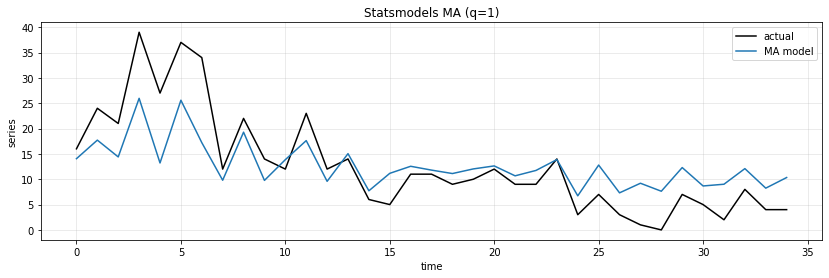

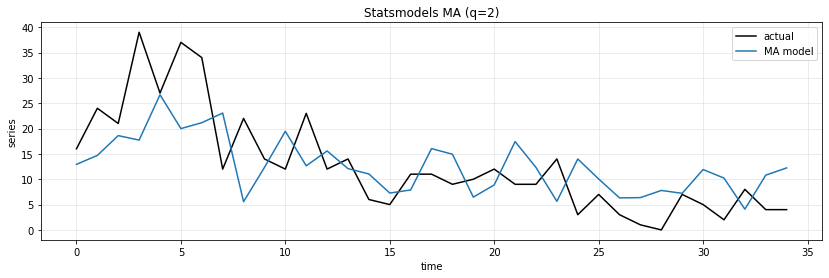

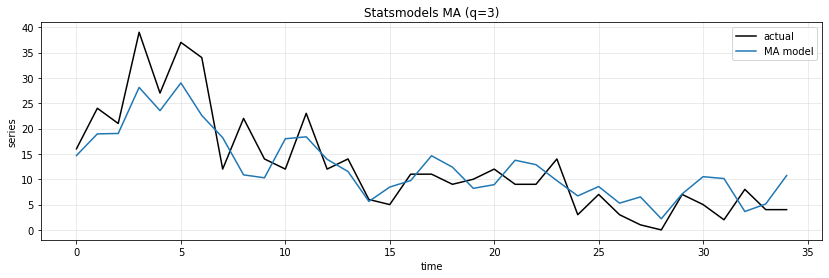

In [106]:
# plot different orders (q's)
for i in range(1,5):
    try:
        model = ARMA(train, (0,i)).fit()
        run_sequence_plot(time, train, title="Statsmodels MA (q={})".format(i))
        plt.plot(time, model.predict(start=1, end=35), label="MA model")
        plt.legend()
        plt.show();
    except:
        pass

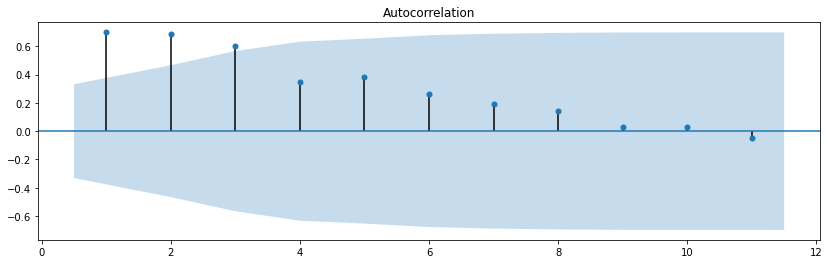

In [93]:
from statsmodels.graphics.tsaplots import plot_acf
fig = plot_acf(train, lags=range(1,12), alpha=0.05)

In [94]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(train)
print(pvalue)

0.38860509165669155


In [95]:
difference = train[:-1] - train[1:]
difference2 = difference[:-1] - difference[1:]

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(difference2)
print(pvalue)

3.492966901767598e-08


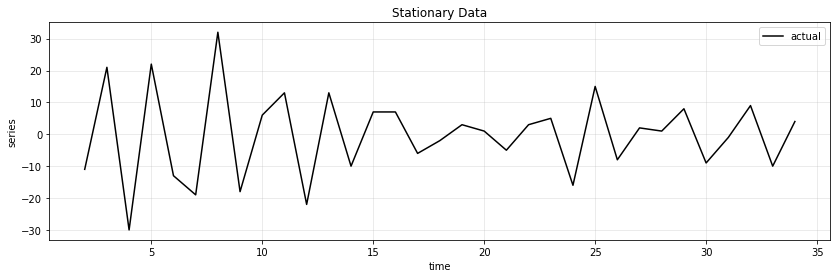

In [96]:
run_sequence_plot(time[2:], difference2, title="Stationary Data")

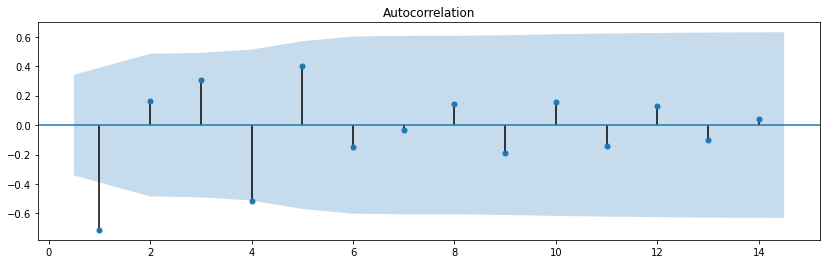

In [97]:
fig = plot_acf(difference2, lags=range(1,15), alpha=0.05)

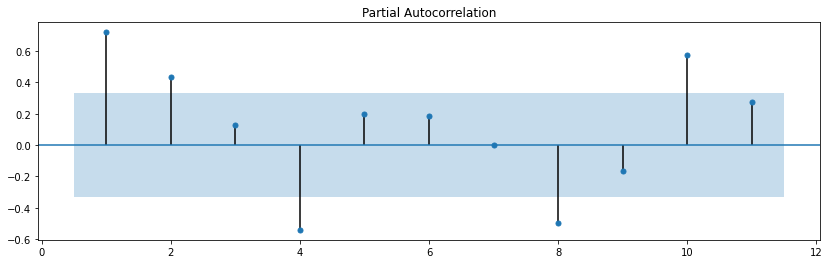

In [99]:
from statsmodels.graphics.tsaplots import plot_pacf

fig = plot_pacf(train, lags=range(1,12), alpha=0.05)

#### Assessing Autocorrelation and Partial Autocorrelation

In [17]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

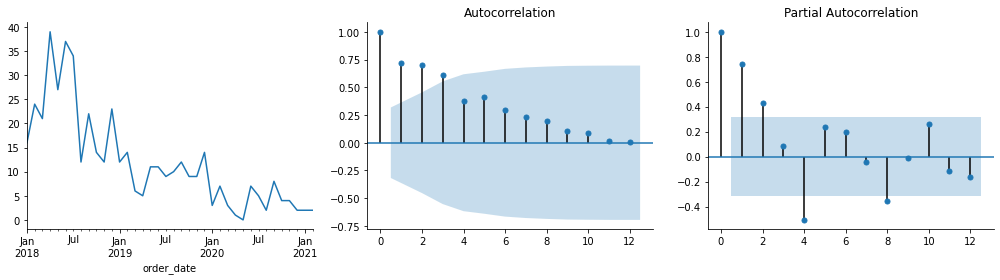

In [105]:
# helper plot for monthly temps
plots(monthly_temp['EFX-FLY-BLK'], lags=12);
# we note a 12-period cycle (yearly), so must use SARIMA

In [133]:
# we might need to install dev version for statespace functionality
#!pip install git+https://github.com/statsmodels/statsmodels.git
import statsmodels.api as sm

# fit SARIMA monthly based on helper plots
sar = sm.tsa.statespace.SARIMAX(monthly_temp['EFX-FLY-BLK'], 
                                order=(0,1,0),              # set p,d,q
                                seasonal_order=(0,1,0,12),  # set seasonal p,d,q,s
                                trend='c').fit()
#sar.summary()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


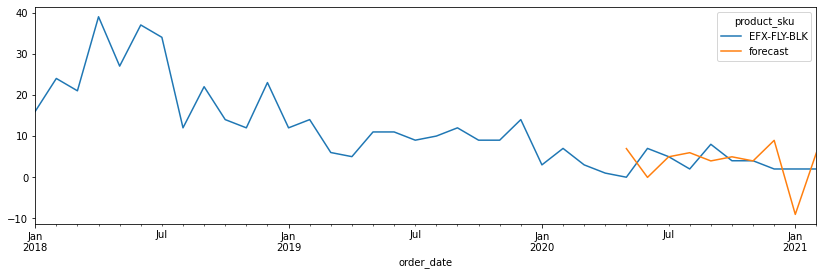

In [134]:
# plot predictions
monthly_temp['forecast'] = sar.predict(start = 28 , end= 38, dynamic=False)  
monthly_temp[['EFX-FLY-BLK', 'forecast']].plot();

In [34]:
warnings.filterwarnings(action='ignore')

# autoselect for monthly, limited to only searching AR and MA parameters: UPDATE MAX_AR AND MA
autores = sm.tsa.arma_order_select_ic(monthly_temp['EFX-FLY-BLK'], 
                                      ic=['aic', 'bic'], 
                                      trend='c', 
                                      max_ar=4, 
                                      max_ma=4, 
                                      fit_kw=dict(method='css-mle'))

print('AIC', autores.aic_min_order) # will use this as inputs for annual
print('BIC', autores.bic_min_order)

AIC (4, 1)
BIC (0, 3)


In [35]:
# SETUP (using itertools to gridsearch solutions)
import itertools

#set parameter range; feel free to update these!
p = q = range(0, 3)
d = range(0, 2)
season = 12

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
# same for seasonal variant
seasonal_pdq = [(x[0], x[1], x[2], season) for x in list(itertools.product(p, d, q))]

print('SARIMAX: {} , {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} , {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} , {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} , {}'.format(pdq[2], seasonal_pdq[4]))

SARIMAX: (0, 0, 1) , (0, 0, 1, 12)
SARIMAX: (0, 0, 1) , (0, 0, 2, 12)
SARIMAX: (0, 0, 2) , (0, 1, 0, 12)
SARIMAX: (0, 0, 2) , (0, 1, 1, 12)


In [40]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_temp['EFX-FLY-BLK'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:325.5371587888973
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:962.2622576099411
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:90.3888123127513
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:212.78679861984222
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:94.59063238715856
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:20.14616008905061
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:179.9025238444263
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1101.8343075899786
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:75.16893136607834
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:106.38408140712963
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:92.8414098587376
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:22.033984200898523
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:79.49495655247547
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:80.15183670075481
ARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:76.79627023713684
ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:24.45266587957224
ARIMA(0, 0, 0)x(2, 1, 1, 12)12 - AIC:26.452577625555723
ARIMA(0, 0, 0)x(2, 1, 2, 12)12 - AIC:23.87624734978365
ARIMA(0

ARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:-1.3747335168852075
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:145.05539334267706
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:1102.2594394800649
ARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:67.07971157826452
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:85.95398513216956
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:80.87351365096869
ARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:5.086514863738641
ARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:71.57103194789941
ARIMA(1, 0, 2)x(2, 0, 1, 12)12 - AIC:71.87699557021614
ARIMA(1, 0, 2)x(2, 0, 2, 12)12 - AIC:68.46909377603156
ARIMA(1, 0, 2)x(2, 1, 0, 12)12 - AIC:-1.9397012997032306
ARIMA(1, 0, 2)x(2, 1, 1, 12)12 - AIC:-8.063546325811501
ARIMA(1, 0, 2)x(2, 1, 2, 12)12 - AIC:7.1343441633139335
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:254.35849984654703
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1027.748190428636
ARIMA(1, 1, 0)x(0, 0, 2, 12)12 - AIC:78.09893004985986
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:186.75443200159924
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:84.56321143272088


ARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:14.898919052278202
ARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:71.17214992614647
ARIMA(2, 1, 1)x(2, 0, 1, 12)12 - AIC:nan
ARIMA(2, 1, 1)x(2, 0, 2, 12)12 - AIC:74.2811202370547
ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:11.15669879350348
ARIMA(2, 1, 1)x(2, 1, 1, 12)12 - AIC:8.86288730184178
ARIMA(2, 1, 1)x(2, 1, 2, 12)12 - AIC:11.151812647073875
ARIMA(2, 1, 2)x(0, 0, 0, 12)12 - AIC:225.2109032463229
ARIMA(2, 1, 2)x(0, 0, 1, 12)12 - AIC:986.2163991900397
ARIMA(2, 1, 2)x(0, 0, 2, 12)12 - AIC:65.90352934709081
ARIMA(2, 1, 2)x(0, 1, 0, 12)12 - AIC:160.01772379027364
ARIMA(2, 1, 2)x(0, 1, 1, 12)12 - AIC:77.6302763897913
ARIMA(2, 1, 2)x(0, 1, 2, 12)12 - AIC:14.0
ARIMA(2, 1, 2)x(1, 0, 0, 12)12 - AIC:143.26183955625456
ARIMA(2, 1, 2)x(1, 0, 1, 12)12 - AIC:995.8400407811032
ARIMA(2, 1, 2)x(1, 0, 2, 12)12 - AIC:66.81003229301635
ARIMA(2, 1, 2)x(1, 1, 0, 12)12 - AIC:83.7131415315242
ARIMA(2, 1, 2)x(1, 1, 1, 12)12 - AIC:78.97896379479872
ARIMA(2, 1, 2)x(1, 1, 2, 12)12 - AIC:

**Source:* https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

## Section 4: ARIMA with Pyflux

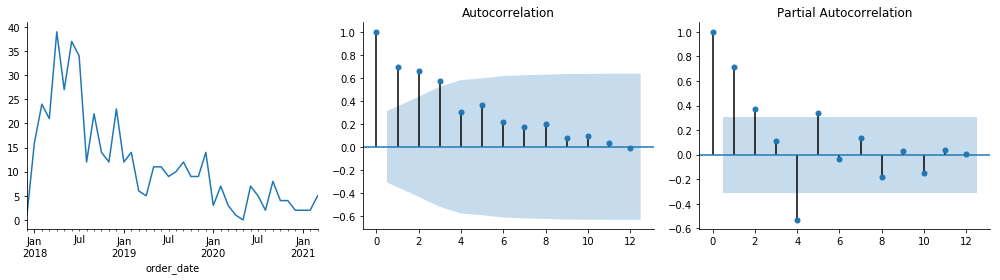

In [28]:
# helper plot
plots(monthly_temp['EFX-FLY-BLK'], lags=12)

In [30]:
# build and summarize model
model = pf.ARIMA(data=monthly_temp, ar=2, ma=2, integ=0, target='EFX-FLY-BLK')
x = model.fit("MLE")
x.summary()

Normal ARIMA(2,0,2)                                                                                       
======================================================= ==================================================
Dependent Variable: EFX-FLY-BLK                         Method: MLE                                       
Start Date: 2018-02-28 00:00:00                         Log Likelihood: -106.0515                         
End Date: 2021-03-31 00:00:00                           AIC: 224.103                                      
Number of observations: 38                              BIC: 233.9285                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.137      1.0363     0.1322   0.8948   (-1.8941 | 2.1681)       
AR(1)                                

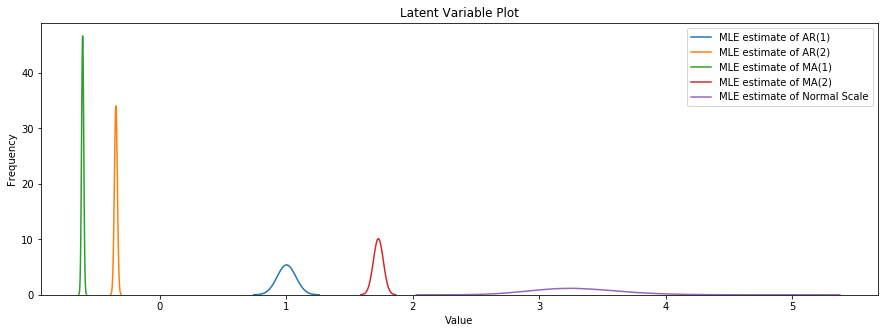

In [31]:
# plot z-scores of feature coefficients
model.plot_z(indices=range(1,9))

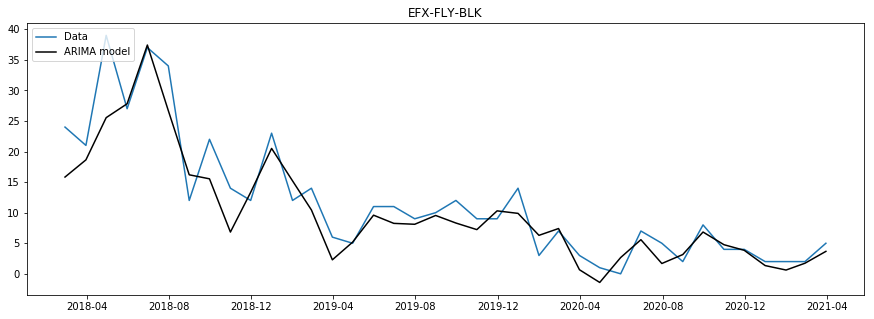

In [32]:
# plot model against raw data
model.plot_fit(figsize=(15,5))

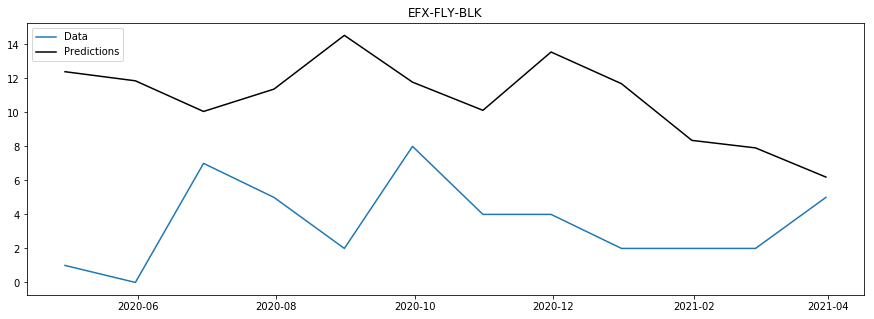

In [34]:
# plot predictions
model.plot_predict_is(12, fit_once=False, figsize=(15,5))

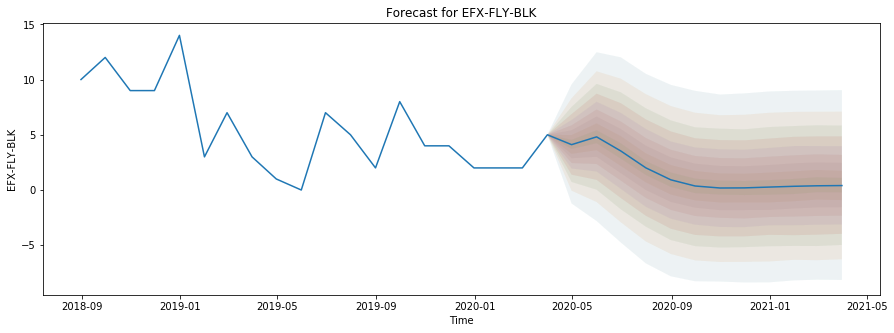

In [36]:
# plot forecast
model.plot_predict(h=12, past_values=20, figsize=(15,5))